# **Adaptive Options Strategy Optimization Using Reinforcement Learning and Time-to-Expiry Dynamics**



---



## **Executive Summary**


This report presents the application of a Proximal Policy Optimization (PPO) reinforcement learning agent in systematic options trading. The agent was trained to dynamically select between directional (calls and puts) and volatility-based (straddles) strategies across multiple equity tickers and time-to-expiry (TTE) settings. It was evaluated against a benchmark straddle strategy using test set performance across AAPL, XOM, JPM, and UNH, each starting with \$100,000 capital.

Results showed the PPO agent consistently matched or exceeded benchmark equity growth, with notable outperformance in UNH, which reached over \$102,500. The model executed rebalancing logic every 15 days in longer expiries (45- and 60-day TTEs), capturing key profit periods in volatile conditions. Equity curves revealed gradual and stable capital accumulation, with rebalancing coinciding with rapid value gains.

Signal visualizations for UNH confirmed the model’s ability to enter calls and puts around strong trends and volatility spikes, using straddles near inflection points. Timely use of puts, especially before sharp price drops, demonstrated effective downside risk mitigation.

The business implication is clear: reinforcement learning can enhance trading precision, automate strategy selection, and adapt to evolving markets. Investors can use this technology to drive capital-efficient, risk-aware portfolio growth with minimal intervention. This positions RL as a transformative engine for next-generation options trading and active risk management.


## **Data Extraction**

This script is intended as the first step toward developing a reinforcement learning pipeline for options trading. Historical price trends of selected U.S. stocks including Apple, ExxonMobil, JPMorgan Chase, and UnitedHealth Group are analyzed to establish a basis for choosing underlyings suitable for RL-based strategies. These tickers are selected for their sector representation, market relevance, and liquidity.

The time frame from January 2020 to the present is used so that different market environments can be captured. This includes the COVID-19 crash, stimulus-driven recovery, inflation periods, and interest rate changes. By reviewing how each stock performed across these conditions, a broader understanding of sector resilience and volatility is gained, which will inform the design of the RL environment.

The following steps are completed in this script:

* Historical closing price data is downloaded using Yahoo Finance
* Missing data is removed and time series are aligned
* Tickers are sorted by latest price for clearer visualization
* Custom colors are applied for sector-level distinction
* An interactive line chart is generated using Plotly for intuitive comparison

This sets up a clean and interpretable dataset that can be extended with indicators, option metrics, and rewards for training RL agents.


In [1]:
! pip install yfinance plotly pandas

In [2]:
# @title Ticker Historical Performance

import yfinance as yf
import pandas as pd
import plotly.graph_objects as go

tickers = ["AAPL", "XOM", "JPM", "UNH"]
start_date = "2020-01-01"
end_date = pd.Timestamp.today().strftime("%Y-%m-%d")

data = yf.download(tickers, start=start_date, end=end_date)["Close"]
data = data.dropna()

latest_prices = data.iloc[-1].round(2)
sorted_tickers = latest_prices.sort_values(ascending=False).index.tolist()

# Define custom colors (change purple to yellow)
custom_colors = {
    "AAPL": "lime",
    "XOM": "royalblue",   # changed from purple
    "JPM": "red",
    "UNH": "orange"
}

fig = go.Figure()

for ticker in sorted_tickers:
    fig.add_trace(go.Scatter(
        x=data.index,
        y=data[ticker].round(2),
        mode='lines',
        name=f"{ticker}",
        line=dict(color=custom_colors.get(ticker, None))
    ))

fig.update_layout(
    title="Stock Close Prices (2020 to Today)",
    xaxis_title="Date",
    yaxis_title="Close Price (USD)",
    template="plotly_dark",
    hovermode="x unified",
    height=600,
    yaxis=dict(tickformat=".2f"),
    legend=dict(traceorder="normal")
)

fig.show()


/tmp/ipython-input-2-6467061.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)["Close"]
[*********************100%***********************]  4 of 4 completed


In [3]:
# @title OHLC Prices per Ticker

ohlc_data = yf.download(tickers, start=start_date, end=end_date, group_by='ticker', auto_adjust=False)

for ticker in tickers:
    df = ohlc_data[ticker].dropna()

    fig = go.Figure(data=[go.Candlestick(
        x=df.index,
        open=df["Open"],
        high=df["High"],
        low=df["Low"],
        close=df["Close"],
        name=ticker
    )])

    fig.update_layout(
        title=f"{ticker} OHLC Chart (2020 to Today)",
        xaxis_title="Date",
        yaxis_title="Price (USD)",
        xaxis_rangeslider_visible=False,
        template="plotly_dark",
        height=600
    )

    fig.show()

[*********************100%***********************]  4 of 4 completed


In [4]:
# @title Price Table per Ticker

from IPython.display import display, HTML

for ticker in tickers:
    df = ohlc_data[ticker][["Open", "High", "Low", "Close", "Volume"]].dropna().head(10)
    df.columns.name = None  # Remove 'Price' column label if present
    formatted_df = df.map(lambda x: f"{x:,.2f}")

    display(HTML(f"<h3><strong>📊 {ticker}</strong></h3>"))
    display(formatted_df)

,Open,High,Low,Close,Volume
Date,,,,,
2020-01-02,74.06,75.15,73.80,75.09,"135,480,400.00"
2020-01-03,74.29,75.14,74.12,74.36,"146,322,800.00"
2020-01-06,73.45,74.99,73.19,74.95,"118,387,200.00"
2020-01-07,74.96,75.22,74.37,74.60,"108,872,000.00"
2020-01-08,74.29,76.11,74.29,75.80,"132,079,200.00"
2020-01-09,76.81,77.61,76.55,77.41,"170,108,400.00"
2020-01-10,77.65,78.17,77.06,77.58,"140,644,800.00"
2020-01-13,77.91,79.27,77.79,79.24,"121,532,000.00"
2020-01-14,79.18,79.39,78.04,78.17,"161,954,400.00"


,Open,High,Low,Close,Volume
Date,,,,,
2020-01-02,70.24,71.02,70.24,70.90,"12,456,400.00"
2020-01-03,71.34,71.37,70.16,70.33,"17,386,900.00"
2020-01-06,70.32,71.36,70.23,70.87,"20,081,900.00"
2020-01-07,70.50,70.52,69.51,70.29,"17,387,700.00"
2020-01-08,70.11,70.29,69.17,69.23,"15,137,700.00"
2020-01-09,69.14,69.90,68.63,69.76,"14,811,800.00"
2020-01-10,69.93,69.96,69.12,69.14,"11,995,600.00"
2020-01-13,69.20,69.87,69.11,69.80,"9,953,900.00"
2020-01-14,69.38,69.58,68.89,69.20,"16,261,000.00"


,Open,High,Low,Close,Volume
Date,,,,,
2020-01-02,139.79,141.10,139.26,141.09,"10,803,700.00"
2020-01-03,137.50,139.23,137.08,138.34,"10,386,800.00"
2020-01-06,136.56,138.27,136.50,138.23,"10,259,000.00"
2020-01-07,137.28,137.86,135.82,135.88,"10,531,300.00"
2020-01-08,135.70,137.58,135.60,136.94,"9,695,300.00"
2020-01-09,138.05,138.23,137.04,137.44,"9,469,000.00"
2020-01-10,137.21,137.25,135.81,136.07,"10,190,900.00"
2020-01-13,136.19,137.20,135.76,137.20,"12,355,200.00"
2020-01-14,137.94,140.76,137.69,138.80,"24,906,000.00"


,Open,High,Low,Close,Volume
Date,,,,,
2020-01-02,293.98,295.70,289.79,292.50,"2,543,400.00"
2020-01-03,287.27,291.88,284.36,289.54,"2,711,400.00"
2020-01-06,288.00,291.66,287.22,291.55,"3,079,100.00"
2020-01-07,290.70,291.49,287.58,289.79,"2,492,900.00"
2020-01-08,291.50,297.38,290.04,295.90,"3,379,200.00"
2020-01-09,294.29,297.20,293.72,294.22,"2,838,200.00"
2020-01-10,296.07,296.07,292.21,295.13,"2,477,900.00"
2020-01-13,294.37,294.45,285.02,285.85,"6,994,900.00"
2020-01-14,285.60,288.24,284.25,288.24,"6,056,300.00"


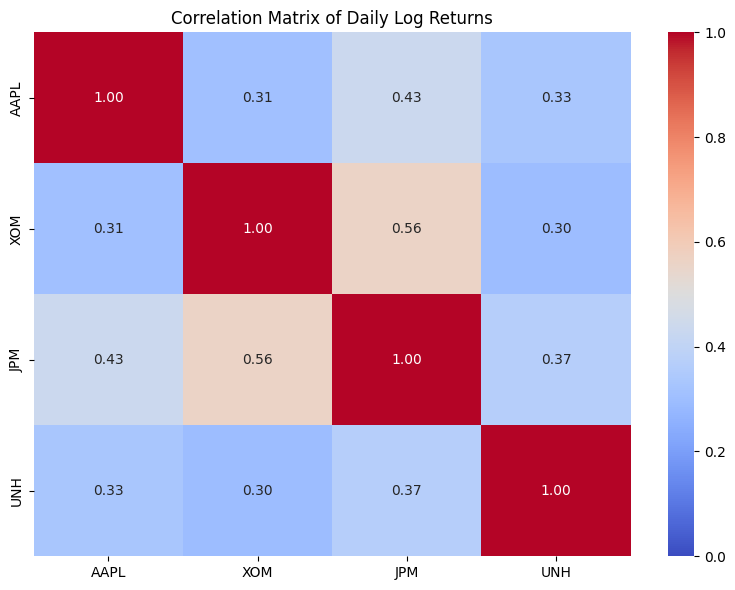

In [7]:
# @title Check for Diversification Tendency

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# === Collect close prices ===
close_prices = pd.DataFrame({
    ticker: ohlc_data[ticker]["Close"]
    for ticker in tickers if "Close" in ohlc_data[ticker]
}).dropna()

# === Compute log returns ===
log_returns = np.log(close_prices / close_prices.shift(1)).dropna()

# === Compute correlation matrix ===
corr_matrix = log_returns.corr()

# === Plot correlation heatmap ===
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=0, vmax=1)
plt.title("Correlation Matrix of Daily Log Returns")
plt.tight_layout()
plt.show()


The correlation matrix of daily log returns for AAPL, XOM, JPM, and UNH demonstrates that these tickers are well-suited for diversification in an investment or options trading portfolio. The values range from **0.30 to 0.56**, indicating only moderate correlations between the assets. For instance, AAPL and XOM exhibit a correlation of **0.31**, AAPL and UNH at **0.33**, and XOM and UNH at **0.30**. These relatively low relationships mean the tickers tend to move independently, which is beneficial when constructing a portfolio designed to withstand volatility and minimize total risk.

From a business and trading perspective, these moderate-to-low correlations suggest strong diversification potential across sectors—technology (AAPL), energy (XOM), financials (JPM), and healthcare (UNH). Even the highest correlation, between XOM and JPM at **0.56**, remains moderate, which limits the risk of synchronized losses during market downturns. For options traders using reinforcement learning strategies, this independence across assets allows for more effective hedging, position balancing, and volatility harvesting. Ultimately, the weak correlations support the construction of a multi-ticker strategy where returns can be smoothed and drawdowns mitigated without sacrificing exposure to various market opportunities.


In [8]:
# ✅ Convert MultiIndex DataFrame into a dict of DataFrames
ohlc_dict = {ticker: ohlc_data[ticker].dropna().copy() for ticker in tickers}

## **Data Augmentation**

In [9]:
# @title Data Augmentation (15-Day Aligned)

import numpy as np
from scipy.stats import norm

# === Black-Scholes Greeks calculator ===
def compute_greeks(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    delta = norm.cdf(d1)
    gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T))
    theta = -(S * norm.pdf(d1) * sigma) / (2 * np.sqrt(T)) - r * K * np.exp(-r * T) * norm.cdf(d2)
    vega = S * norm.pdf(d1) * np.sqrt(T)

    return delta, gamma, theta, vega

# === Main augmentation loop with 15-day alignment ===
for ticker in tickers:
    df = ohlc_dict[ticker][["Open", "High", "Low", "Close", "Volume"]].dropna()

    # === 15-day aligned indicators ===
    df["log_return"] = np.log(df["Close"] / df["Close"].shift(1))
    df["volatility_15d"] = df["log_return"].rolling(window=15).std()
    df["momentum_15d"] = df["Close"].pct_change(periods=15)
    df["drawdown_15d"] = df["Close"] / df["Close"].rolling(window=15).max() - 1

    roll_mean = df["log_return"].rolling(15).mean()
    roll_std = df["log_return"].rolling(15).std()
    df["sharpe_15d"] = roll_mean / roll_std

    downside_std = df["log_return"].rolling(15).apply(lambda x: np.std(x[x < 0]), raw=False)
    df["sortino_15d"] = roll_mean / downside_std

    # RSI using 15-day window
    delta = df["Close"].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(15).mean()
    avg_loss = loss.rolling(15).mean()
    rs = avg_gain / avg_loss
    df["RSI_15"] = 100 - (100 / (1 + rs))

    # MACD (unchanged)
    ema_12 = df["Close"].ewm(span=12, adjust=False).mean()
    ema_26 = df["Close"].ewm(span=26, adjust=False).mean()
    df["MACD"] = ema_12 - ema_26
    df["MACD_signal"] = df["MACD"].ewm(span=9, adjust=False).mean()

    # BB(15)
    ma_15 = df["Close"].rolling(window=15).mean()
    std_15 = df["Close"].rolling(window=15).std()
    df["BB_width_15"] = (ma_15 + 2 * std_15) - (ma_15 - 2 * std_15)
    df["price_to_ma15"] = df["Close"] / ma_15

    # Other intraday + volatility indicators
    df["range_pct"] = (df["High"] - df["Low"]) / df["Close"]
    df["avg_price"] = (df["High"] + df["Low"]) / 2
    df["price_range"] = df["High"] - df["Low"]
    df["price_change"] = df["Close"] - df["Open"]
    df["gap_pct"] = (df["Open"] - df["Close"].shift(1)) / df["Close"].shift(1)
    df["vol_spike"] = df["Volume"] / df["Volume"].rolling(15).mean()
    df["day_volatility"] = (df["High"] - df["Low"]) / df["Open"]

    # === Greeks (T = 30d fixed) ===
    T = 30 / 365
    r = 0.05
    sigma = df["volatility_15d"].fillna(method='bfill')

    df["K_call"] = df["Close"] * 1.05
    df["K_put"] = df["Close"] * 0.95

    greeks_call = df.apply(lambda row: compute_greeks(row["Close"], row["K_call"], T, r, row["volatility_15d"]), axis=1)
    df[["Delta_call", "Gamma_call", "Theta_call", "Vega_call"]] = pd.DataFrame(greeks_call.tolist(), index=df.index)

    greeks_put = df.apply(lambda row: compute_greeks(row["Close"], row["K_put"], T, r, row["volatility_15d"]), axis=1)
    df["Delta_put"] = greeks_put.apply(lambda g: g[0] - 1)
    df[["Gamma_put", "Theta_put", "Vega_put"]] = pd.DataFrame(greeks_put.tolist(), index=df.index)[[1, 2, 3]]

    # === Display and Store ===
    df.columns.name = None
    formatted_df = df.head(10).map(lambda x: f"{x:,.2f}")
    display(HTML(f"<h3><strong>📊 {ticker}</strong></h3>"))
    display(formatted_df)

    ohlc_dict[ticker] = df


/tmp/ipython-input-9-1933765521.py:68: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



,Open,High,Low,Close,Volume,log_return,volatility_15d,momentum_15d,drawdown_15d,sharpe_15d,...,K_call,K_put,Delta_call,Gamma_call,Theta_call,Vega_call,Delta_put,Gamma_put,Theta_put,Vega_put
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,74.06,75.15,73.80,75.09,"135,480,400.00",nan,nan,nan,nan,nan,...,78.84,71.33,nan,nan,nan,nan,nan,nan,nan,nan
2020-01-03,74.29,75.14,74.12,74.36,"146,322,800.00",-0.01,nan,nan,nan,nan,...,78.08,70.64,nan,nan,nan,nan,nan,nan,nan,nan
2020-01-06,73.45,74.99,73.19,74.95,"118,387,200.00",0.01,nan,nan,nan,nan,...,78.70,71.20,nan,nan,nan,nan,nan,nan,nan,nan
2020-01-07,74.96,75.22,74.37,74.60,"108,872,000.00",-0.00,nan,nan,nan,nan,...,78.33,70.87,nan,nan,nan,nan,nan,nan,nan,nan
2020-01-08,74.29,76.11,74.29,75.80,"132,079,200.00",0.02,nan,nan,nan,nan,...,79.59,72.01,nan,nan,nan,nan,nan,nan,nan,nan
2020-01-09,76.81,77.61,76.55,77.41,"170,108,400.00",0.02,nan,nan,nan,nan,...,81.28,73.54,nan,nan,nan,nan,nan,nan,nan,nan
2020-01-10,77.65,78.17,77.06,77.58,"140,644,800.00",0.00,nan,nan,nan,nan,...,81.46,73.70,nan,nan,nan,nan,nan,nan,nan,nan
2020-01-13,77.91,79.27,77.79,79.24,"121,532,000.00",0.02,nan,nan,nan,nan,...,83.20,75.28,nan,nan,nan,nan,nan,nan,nan,nan
2020-01-14,79.18,79.39,78.04,78.17,"161,954,400.00",-0.01,nan,nan,nan,nan,...,82.08,74.26,nan,nan,nan,nan,nan,nan,nan,nan


/tmp/ipython-input-9-1933765521.py:68: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



,Open,High,Low,Close,Volume,log_return,volatility_15d,momentum_15d,drawdown_15d,sharpe_15d,...,K_call,K_put,Delta_call,Gamma_call,Theta_call,Vega_call,Delta_put,Gamma_put,Theta_put,Vega_put
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,70.24,71.02,70.24,70.90,"12,456,400.00",nan,nan,nan,nan,nan,...,74.45,67.36,nan,nan,nan,nan,nan,nan,nan,nan
2020-01-03,71.34,71.37,70.16,70.33,"17,386,900.00",-0.01,nan,nan,nan,nan,...,73.85,66.81,nan,nan,nan,nan,nan,nan,nan,nan
2020-01-06,70.32,71.36,70.23,70.87,"20,081,900.00",0.01,nan,nan,nan,nan,...,74.41,67.33,nan,nan,nan,nan,nan,nan,nan,nan
2020-01-07,70.50,70.52,69.51,70.29,"17,387,700.00",-0.01,nan,nan,nan,nan,...,73.80,66.78,nan,nan,nan,nan,nan,nan,nan,nan
2020-01-08,70.11,70.29,69.17,69.23,"15,137,700.00",-0.02,nan,nan,nan,nan,...,72.69,65.77,nan,nan,nan,nan,nan,nan,nan,nan
2020-01-09,69.14,69.90,68.63,69.76,"14,811,800.00",0.01,nan,nan,nan,nan,...,73.25,66.27,nan,nan,nan,nan,nan,nan,nan,nan
2020-01-10,69.93,69.96,69.12,69.14,"11,995,600.00",-0.01,nan,nan,nan,nan,...,72.60,65.68,nan,nan,nan,nan,nan,nan,nan,nan
2020-01-13,69.20,69.87,69.11,69.80,"9,953,900.00",0.01,nan,nan,nan,nan,...,73.29,66.31,nan,nan,nan,nan,nan,nan,nan,nan
2020-01-14,69.38,69.58,68.89,69.20,"16,261,000.00",-0.01,nan,nan,nan,nan,...,72.66,65.74,nan,nan,nan,nan,nan,nan,nan,nan


/tmp/ipython-input-9-1933765521.py:68: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



,Open,High,Low,Close,Volume,log_return,volatility_15d,momentum_15d,drawdown_15d,sharpe_15d,...,K_call,K_put,Delta_call,Gamma_call,Theta_call,Vega_call,Delta_put,Gamma_put,Theta_put,Vega_put
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,139.79,141.10,139.26,141.09,"10,803,700.00",nan,nan,nan,nan,nan,...,148.14,134.04,nan,nan,nan,nan,nan,nan,nan,nan
2020-01-03,137.50,139.23,137.08,138.34,"10,386,800.00",-0.02,nan,nan,nan,nan,...,145.26,131.42,nan,nan,nan,nan,nan,nan,nan,nan
2020-01-06,136.56,138.27,136.50,138.23,"10,259,000.00",-0.00,nan,nan,nan,nan,...,145.14,131.32,nan,nan,nan,nan,nan,nan,nan,nan
2020-01-07,137.28,137.86,135.82,135.88,"10,531,300.00",-0.02,nan,nan,nan,nan,...,142.67,129.09,nan,nan,nan,nan,nan,nan,nan,nan
2020-01-08,135.70,137.58,135.60,136.94,"9,695,300.00",0.01,nan,nan,nan,nan,...,143.79,130.09,nan,nan,nan,nan,nan,nan,nan,nan
2020-01-09,138.05,138.23,137.04,137.44,"9,469,000.00",0.00,nan,nan,nan,nan,...,144.31,130.57,nan,nan,nan,nan,nan,nan,nan,nan
2020-01-10,137.21,137.25,135.81,136.07,"10,190,900.00",-0.01,nan,nan,nan,nan,...,142.87,129.27,nan,nan,nan,nan,nan,nan,nan,nan
2020-01-13,136.19,137.20,135.76,137.20,"12,355,200.00",0.01,nan,nan,nan,nan,...,144.06,130.34,nan,nan,nan,nan,nan,nan,nan,nan
2020-01-14,137.94,140.76,137.69,138.80,"24,906,000.00",0.01,nan,nan,nan,nan,...,145.74,131.86,nan,nan,nan,nan,nan,nan,nan,nan


/tmp/ipython-input-9-1933765521.py:68: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



,Open,High,Low,Close,Volume,log_return,volatility_15d,momentum_15d,drawdown_15d,sharpe_15d,...,K_call,K_put,Delta_call,Gamma_call,Theta_call,Vega_call,Delta_put,Gamma_put,Theta_put,Vega_put
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,293.98,295.70,289.79,292.50,"2,543,400.00",nan,nan,nan,nan,nan,...,307.12,277.88,nan,nan,nan,nan,nan,nan,nan,nan
2020-01-03,287.27,291.88,284.36,289.54,"2,711,400.00",-0.01,nan,nan,nan,nan,...,304.02,275.06,nan,nan,nan,nan,nan,nan,nan,nan
2020-01-06,288.00,291.66,287.22,291.55,"3,079,100.00",0.01,nan,nan,nan,nan,...,306.13,276.97,nan,nan,nan,nan,nan,nan,nan,nan
2020-01-07,290.70,291.49,287.58,289.79,"2,492,900.00",-0.01,nan,nan,nan,nan,...,304.28,275.30,nan,nan,nan,nan,nan,nan,nan,nan
2020-01-08,291.50,297.38,290.04,295.90,"3,379,200.00",0.02,nan,nan,nan,nan,...,310.69,281.10,nan,nan,nan,nan,nan,nan,nan,nan
2020-01-09,294.29,297.20,293.72,294.22,"2,838,200.00",-0.01,nan,nan,nan,nan,...,308.93,279.51,nan,nan,nan,nan,nan,nan,nan,nan
2020-01-10,296.07,296.07,292.21,295.13,"2,477,900.00",0.00,nan,nan,nan,nan,...,309.89,280.37,nan,nan,nan,nan,nan,nan,nan,nan
2020-01-13,294.37,294.45,285.02,285.85,"6,994,900.00",-0.03,nan,nan,nan,nan,...,300.14,271.56,nan,nan,nan,nan,nan,nan,nan,nan
2020-01-14,285.60,288.24,284.25,288.24,"6,056,300.00",0.01,nan,nan,nan,nan,...,302.65,273.83,nan,nan,nan,nan,nan,nan,nan,nan


This data augmentation process is performed to enrich the input features for reinforcement learning in options trading. By computing diverse technical and statistical indicators, a more informative and robust state space is created for the agent. This allows patterns to be learned across volatility, momentum, trend strength, and risk-adjusted return behavior, supporting better decision-making across different market conditions. All features are aligned on a consistent 15-day basis to match the rebalancing logic in the options strategy.

The augmentation also contributes to diversification in both feature and strategy space. By including Greeks, volatility spikes, MACD, Bollinger Bands, and RSI, the agent is exposed to varied aspects of price behavior. This allows the RL model to adapt to different underlyings and regimes, improving generalization across tickers and reducing overfitting to any single signal type. It ensures the environment reflects multiple strategy types, including directional, volatility, and range-bound trades (Wen, Yuan, & Yang, 2021).

Essential augmentation includes:

* Log returns computed as
  `log_return = ln(Close_t / Close_{t-1})`
* Volatility estimated as a rolling standard deviation over 15 days
* Sharpe and Sortino ratios used to measure return per unit of risk
  `Sharpe = mean(returns) / std(returns)`
  `Sortino = mean(returns) / std(negative returns)`
* Bollinger Band width and price relative to 15-day moving average used to capture price expansion and mean-reversion
* RSI and MACD calculated to quantify trend and momentum signals
* Option Greeks computed using the Black-Scholes model for both calls and puts
  These include
  `Delta`, `Gamma`, `Theta`, and `Vega` with
  `T = 30 / 365`, `r = 0.05`, `σ = volatility_15d`
* Intraday range, gap, and volume spike indicators used to add short-term dynamics

By applying this augmentation across multiple tickers, the environment is diversified in both inputs and behavior, allowing reinforcement learning to be trained on more realistic, non-redundant, and sector-varied data.


## **Reinforcement Learning (RL) Preperation**

In [10]:
# @title Train-Test Split (70/30)

train_test_split_dict = {}

for ticker, df in ohlc_dict.items():
    df = df.dropna(subset=[
        "RSI_15", "MACD", "MACD_signal", "momentum_15d",
        "volatility_15d", "BB_width_15", "Close"
    ])
    if df.empty or len(df) < 100:
        print(f"⚠️ Skipping {ticker} — not enough valid data.")
        continue

    split_idx = int(0.7 * len(df))
    train_df = df.iloc[:split_idx].reset_index(drop=True)
    test_df = df.iloc[split_idx:].reset_index(drop=True)

    train_test_split_dict[ticker] = {"train": train_df, "test": test_df}

    print(f"✅ {ticker}: Train size = {len(train_df)}, Test size = {len(test_df)}")


✅ AAPL: Train size = 964, Test size = 414
✅ XOM: Train size = 964, Test size = 414
✅ JPM: Train size = 964, Test size = 414
✅ UNH: Train size = 964, Test size = 414


A 70/30 train-test split is applied to structure the data for reinforcement learning in options trading. The first 70 percent of the data is used to train the model on historical patterns, while the remaining 30 percent is reserved to evaluate how well the model performs on unseen data.

This approach serves several purposes:

* It prevents data leakage by ensuring the model does not learn from future information
* It allows the model’s decision-making to be tested in realistic, forward-looking scenarios
* It supports time-dependent validation, which is essential for financial time series
* It provides a consistent method for comparing results across different tickers and market regimes


In [11]:
! pip install gymnasium

In [12]:
!pip install stable-baselines3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 691.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 32.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-c

In [13]:
# @title Manual Action Assignment

for ticker, split_data in train_test_split_dict.items():
    for split in ["train", "test"]:
        df = split_data[split]

        # Generate signals only if missing
        if "buy_call_signal" not in df.columns:
            df["buy_call_signal"] = (
                (df["RSI_15"] > 50) & (df["MACD"] > df["MACD_signal"]) & (df["momentum_15d"] > 0)
            ).astype(int)

        if "sell_call_signal" not in df.columns:
            df["sell_call_signal"] = (
                (df["RSI_15"] < 50) | (df["MACD"] < df["MACD_signal"]) | (df["momentum_15d"] < 0)
            ).astype(int)

        if "buy_put_signal" not in df.columns:
            df["buy_put_signal"] = (
                (df["RSI_15"] < 50) & (df["MACD"] < df["MACD_signal"]) & (df["momentum_15d"] < 0)
            ).astype(int)

        if "sell_put_signal" not in df.columns:
            df["sell_put_signal"] = (
                (df["RSI_15"] > 50) | (df["MACD"] > df["MACD_signal"]) | (df["momentum_15d"] > 0)
            ).astype(int)

        if "straddle_signal" not in df.columns:
            df["straddle_signal"] = (
                (df["BB_width_15"] > df["BB_width_15"].rolling(15).mean()) &
                (df["volatility_15d"] > df["volatility_15d"].rolling(15).mean())
            ).astype(int)

        # ✅ Map signals to actions (0–5 only, no action 6)
        action = np.zeros(len(df), dtype=int)
        action[df["buy_call_signal"] == 1] = 1
        action[df["sell_call_signal"] == 1] = 2
        action[df["buy_put_signal"] == 1] = 3
        action[df["sell_put_signal"] == 1] = 4
        action[df["straddle_signal"] == 1] = 5

        df["action"] = action
        train_test_split_dict[ticker][split] = df

        print(f"✅ {ticker} ({split}) — Aligned actions assigned (0–5 only)")


✅ AAPL (train) — Aligned actions assigned (0–5 only)
✅ AAPL (test) — Aligned actions assigned (0–5 only)
✅ XOM (train) — Aligned actions assigned (0–5 only)
✅ XOM (test) — Aligned actions assigned (0–5 only)
✅ JPM (train) — Aligned actions assigned (0–5 only)
✅ JPM (test) — Aligned actions assigned (0–5 only)
✅ UNH (train) — Aligned actions assigned (0–5 only)
✅ UNH (test) — Aligned actions assigned (0–5 only)


Manual action labels are assigned based on combinations of technical indicators to define what trading decision should be taken at each point in time. The signals rely on momentum (RSI and MACD), directional strength (15-day momentum), and volatility expansion (Bollinger Band width and rolling standard deviation). Each condition is framed as a binary decision and converted into an integer action that represents a specific option strategy. This creates a structured action space needed for reinforcement learning and allows the agent to learn from labeled decisions tied to market behavior (Li, 2024).

The signals are constructed as follows:

* A buy call signal is triggered when
  `RSI_15 > 50` and `MACD > MACD_signal` and `momentum_15d > 0`
* A buy put signal occurs when
  `RSI_15 < 50` and `MACD < MACD_signal` and `momentum_15d < 0`
* A straddle signal is activated when
  `BB_width_15 > mean(BB_width_15)` and `volatility_15d > mean(volatility_15d)`
* Sell signals for calls and puts are activated when one or more of the conditions for their respective buy signals no longer hold
* Each signal is assigned to an action code between 1 and 5, and 0 is used when no signal is active

These labeled actions provide a useful baseline for reinforcement learning to compare against, support policy training, and ensure consistency in decision-making logic across the dataset.


In [14]:
# @title Reward Engine

# Constants
tte_list = [5, 15, 30, 45, 60]
rebalance_start = 45
rebalance_interval = 15

# Helper to compute CAGR and RAROC
def compute_cagr_raroc(equity_curve):
    if len(equity_curve) < 2:
        return np.nan, np.nan

    equity_arr = np.array(equity_curve)
    returns = pd.Series(np.diff(equity_arr) / equity_arr[:-1])

    cagr = (equity_arr[-1] / equity_arr[0]) ** (252 / len(returns)) - 1
    raroc = (returns.mean() / returns.std()) * np.sqrt(252) if returns.std() > 0 else 0

    return round(cagr * 100, 2), round(raroc, 2)

# === Main Reward Loop
for ticker, split_data in train_test_split_dict.items():
    for split in ["train", "test"]:
        df = split_data[split].copy().reset_index(drop=True)

        required_signals = [
            "buy_call_signal", "sell_call_signal",
            "buy_put_signal", "sell_put_signal",
            "straddle_signal"
        ]
        if not all(col in df.columns for col in required_signals):
            print(f"⚠️ Skipping {ticker} {split} — missing signal columns.")
            continue

        df["total_pnl"] = 0.0
        df["reward"] = 0.0
        df["reward_straddle"] = 0.0
        df["equity"] = 100_000  # starting capital
        equity_curve = [100_000]

        for tte in tte_list:
            return_col = f"return_{tte}d"
            df[return_col] = df["Close"].shift(-tte) - df["Close"]

            call_pnl = pd.Series(0.0, index=df.index)
            put_pnl = pd.Series(0.0, index=df.index)
            straddle_pnl = pd.Series(0.0, index=df.index)

            rebalance_mask = ((df.index - rebalance_start) % rebalance_interval == 0) & (df.index >= rebalance_start)

            call_buy = (df["buy_call_signal"] == 1) & rebalance_mask
            call_sell = (df["sell_call_signal"] == 1) & rebalance_mask
            put_buy = (df["buy_put_signal"] == 1) & rebalance_mask
            put_sell = (df["sell_put_signal"] == 1) & rebalance_mask
            straddle_mask = (df["straddle_signal"] == 1) & rebalance_mask

            call_pnl[call_buy] = df[return_col][call_buy]
            call_pnl[call_sell] = -df[return_col][call_sell]
            put_pnl[put_buy] = -df[return_col][put_buy]
            put_pnl[put_sell] = df[return_col][put_sell]
            straddle_pnl[straddle_mask] = 2 * df[return_col].abs()[straddle_mask]

            if tte >= rebalance_start and (tte - rebalance_start) % rebalance_interval == 0:
                df[f"reward_{tte}d"] = call_pnl + put_pnl
                df[f"reward_straddle_{tte}d"] = straddle_pnl
                df["total_pnl"] += df[f"reward_{tte}d"] + df[f"reward_straddle_{tte}d"]
                df["reward_straddle"] += df[f"reward_straddle_{tte}d"]

        df["reward"] = df["total_pnl"]
        df["equity"] = df["reward"].cumsum() + 100_000
        equity_curve = df["equity"].tolist()

        # === Compute Metrics
        total_reward = df["reward"].sum()
        total_straddle = df["reward_straddle"].sum()
        wins = df["reward"][df["reward"] > 0].count()
        losses = df["reward"][df["reward"] < 0].count()
        profit_factor = (
            df["reward"][df["reward"] > 0].sum() / abs(df["reward"][df["reward"] < 0].sum())
            if losses > 0 else np.nan
        )
        win_rate = wins / (wins + losses) if (wins + losses) > 0 else np.nan
        cagr, raroc = compute_cagr_raroc(equity_curve)

        # ✅ Save back
        train_test_split_dict[ticker][split] = df

        print(f"\n📈 {ticker} ({split})")
        print(f"Total Reward: {total_reward:.2f}")
        print(f"Straddle-Only Reward: {total_straddle:.2f}")
        print(f"Win Rate: {win_rate:.2%}")
        print(f"Profit Factor: {profit_factor:.2f}")
        print(f"CAGR: {cagr:.2f}%")
        print(f"RAROC: {raroc:.2f}")



📈 AAPL (train)
Total Reward: 1225.04
Straddle-Only Reward: 905.68
Win Rate: 71.43%
Profit Factor: 3.13
CAGR: 0.32%
RAROC: 1.28

📈 AAPL (test)
Total Reward: 403.34
Straddle-Only Reward: 651.28
Win Rate: 64.29%
Profit Factor: 2.04
CAGR: 0.25%
RAROC: 0.76

📈 XOM (train)
Total Reward: 458.42
Straddle-Only Reward: 475.78
Win Rate: 69.44%
Profit Factor: 2.51
CAGR: 0.12%
RAROC: 1.01

📈 XOM (test)
Total Reward: 193.06
Straddle-Only Reward: 205.82
Win Rate: 64.29%
Profit Factor: 3.12
CAGR: 0.12%
RAROC: 0.97

📈 JPM (train)
Total Reward: 730.28
Straddle-Only Reward: 866.26
Win Rate: 58.33%
Profit Factor: 2.13
CAGR: 0.19%
RAROC: 0.81

📈 JPM (test)
Total Reward: 143.62
Straddle-Only Reward: 632.68
Win Rate: 68.75%
Profit Factor: 1.31
CAGR: 0.09%
RAROC: 0.37

📈 UNH (train)
Total Reward: 448.86
Straddle-Only Reward: 2471.58
Win Rate: 54.05%
Profit Factor: 1.24
CAGR: 0.12%
RAROC: 0.26

📈 UNH (test)
Total Reward: 1141.30
Straddle-Only Reward: 2715.08
Win Rate: 64.29%
Profit Factor: 1.76
CAGR: 0.69%
RA

This reward engine script simulates the performance of a multi-strategy options trading system using predefined signals (buy/sell calls/puts and straddles) across different time-to-expiry (TTE) horizons. It is designed to work on both train and test splits of historical data per ticker. The calculated results act as a blueprint or the agent to study, train, and test itself to the best performance. Here’s what it accomplishes in business terms:


**1. Strategy Execution and Signal-Based PnL Simulation**

* The code applies trading logic over a range of time-to-expiry values: `[5, 15, 30, 45, 60]` days.
* Rebalancing logic kicks in from **TTE = 45 days**, at a **15-day interval**, aligning with realistic options portfolio management.
* For each signal:

  * A **call buy** profits when the stock price rises.
  * A **put buy** profits when the stock price falls.
  * **Straddle positions** profit from volatility (absolute price movement).
* The PnL for each trade is simulated using the return over the holding period:

  $$
  \text{Return}_{TTE} = \text{Close}_{t+TTE} - \text{Close}_t
  $$


**2. Reward Construction for Reinforcement Learning**

* Total reward is computed as the sum of:

  * Directional (buy/sell calls and puts) profits/losses
  * Volatility-based (straddle) profits
* The resulting reward is used to construct an **equity curve**, which simulates the portfolio’s value over time:

  $$
  \text{Equity}_t = 100{,}000 + \sum_{i=1}^t \text{Reward}_i
  $$
* This reward modeling provides ground truth for evaluating how well a reinforcement learning (RL) agent’s policy aligns with profitability.


**3. Performance Metrics for Strategy Evaluation**

* The engine computes key business KPIs to measure profitability and risk:

  * **CAGR (Compound Annual Growth Rate)**:

    $$
    \text{CAGR} = \left( \frac{V_{\text{end}}}{V_{\text{start}}} \right)^{\frac{252}{N}} - 1
    $$

    where $N$ is the number of periods (e.g., days), assuming 252 trading days.
  * **RAROC (Risk-Adjusted Return on Capital)**:

    $$
    \text{RAROC} = \frac{\mu_{\text{return}}}{\sigma_{\text{return}}} \cdot \sqrt{252}
    $$
  * **Profit Factor**: ratio of total gains to total losses.
  * **Win Rate**: percentage of trades with positive reward.

These outputs allow business stakeholders to evaluate whether the agent’s learned strategies would perform well in production — balancing directional exposure, volatility capture, and risk-adjusted performance (Lin & Zhang, 2025).


In [15]:
# @title Aligned Option Strategy Environment with Reward Metrics (Directional + Buy Straddle)

import gym
from gym import spaces

class OptionStrategyEnv(gym.Env):
    def __init__(self, df, tte_list=[15, 30, 45, 60], rebalance_interval=15):
        super(OptionStrategyEnv, self).__init__()
        self.df = df.reset_index(drop=True)
        self.tte_list = tte_list
        self.rebalance_interval = rebalance_interval

        self.action_space = spaces.Discrete(6)  # 0 to 5: Hold, BuyC, SellC, BuyP, SellP, BuyStraddle
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf,
            shape=(len(self._get_observation(0)),),
            dtype=np.float32
        )

        self.starting_capital = 100_000
        self.reset()

    def _get_observation(self, step):
        features = [
            "RSI_15", "MACD", "MACD_signal", "momentum_15d",
            "volatility_15d", "BB_width_15", "sharpe_15d", "sortino_15d"
        ]
        obs = self.df.loc[step, features].fillna(0).values
        return np.clip(obs.astype(np.float32), -10, 10)

    def reset(self):
        self.current_step = 45
        self.cash = self.starting_capital
        self.equity = self.starting_capital

        self.benchmark_cash = self.starting_capital
        self.benchmark_equity = self.starting_capital

        self.equity_curve = [self.equity]
        self.benchmark_curve = [self.benchmark_equity]
        self.reward_history = []

        return self._get_observation(self.current_step)

    def step(self, action):
        done = self.current_step >= len(self.df) - max(self.tte_list)
        reward = 0.0
        benchmark_reward = 0.0

        if not done and (self.current_step - 45) % self.rebalance_interval == 0:
            for tte in self.tte_list:
                if self.current_step + tte >= len(self.df):
                    continue

                fwd_return = (
                    self.df["Close"].iloc[self.current_step + tte]
                    - self.df["Close"].iloc[self.current_step]
                )

                # === Agent reward logic ===
                if action == 1: reward += fwd_return              # Buy Call
                elif action == 2: reward += -fwd_return           # Sell Call
                elif action == 3: reward += -fwd_return           # Buy Put
                elif action == 4: reward += fwd_return            # Sell Put
                elif action == 5: reward += 2 * abs(fwd_return)   # Buy Straddle

                # === Benchmark reward: systematic straddle for comparison ===
                benchmark_reward += 2 * abs(fwd_return)

        self.cash += reward
        self.equity = self.cash

        self.benchmark_cash += benchmark_reward
        self.benchmark_equity = self.benchmark_cash

        self.reward_history.append(reward)
        self.equity_curve.append(self.equity)
        self.benchmark_curve.append(self.benchmark_equity)

        self.current_step += 1
        return self._get_observation(self.current_step), float(reward), done, {}

    def evaluate(self):
        """Compute agent metrics: CAGR, Win Rate, Profit Factor, RAROC"""
        if len(self.equity_curve) < 2:
            return {}

        equity_arr = np.array(self.equity_curve)
        returns = pd.Series(np.diff(equity_arr) / equity_arr[:-1])

        cagr = (equity_arr[-1] / equity_arr[0]) ** (252 / len(returns)) - 1
        win_rate = (returns > 0).mean()
        profit_factor = (
            returns[returns > 0].sum() / abs(returns[returns < 0].sum())
            if (returns < 0).sum() != 0 else np.nan
        )
        raroc = (returns.mean() / returns.std()) * np.sqrt(252) if returns.std() > 0 else 0

        return {
            "CAGR (%)": round(cagr * 100, 2),
            "Win Rate (%)": round(win_rate * 100, 2),
            "Profit Factor": round(profit_factor, 2),
            "RAROC": round(raroc, 2),
            "Final Equity ($)": round(equity_arr[-1], 2)
        }

    def evaluate_benchmark(self):
        """Compute benchmark metrics: same structure as agent"""
        if len(self.benchmark_curve) < 2:
            return {}

        equity_arr = np.array(self.benchmark_curve)
        returns = pd.Series(np.diff(equity_arr) / equity_arr[:-1])

        cagr = (equity_arr[-1] / equity_arr[0]) ** (252 / len(returns)) - 1
        win_rate = (returns > 0).mean()
        profit_factor = (
            returns[returns > 0].sum() / abs(returns[returns < 0].sum())
            if (returns < 0).sum() != 0 else np.nan
        )
        raroc = (returns.mean() / returns.std()) * np.sqrt(252) if returns.std() > 0 else 0

        return {
            "CAGR (%)": round(cagr * 100, 2),
            "Win Rate (%)": round(win_rate * 100, 2),
            "Profit Factor": round(profit_factor, 2),
            "RAROC": round(raroc, 2),
            "Final Equity ($)": round(equity_arr[-1], 2)
        }


This custom `OptionStrategyEnv` simulates a trading environment where an agent learns to manage a portfolio of option strategies based on market features. The agent is given key indicators like RSI, MACD, momentum, volatility, and risk-adjusted return measures, and it makes decisions at fixed rebalancing intervals (every 15 steps). The actions available allow the agent to take either directional positions (through calls or puts) or non-directional volatility exposure (through straddles). The environment computes rewards based on how these actions perform across several time-to-expiry (TTE) settings—15, 30, 45, and 60 days, capturing both short- and medium-term price movement outcomes. This allows the agent to dynamically adjust its strategy according to market conditions, such as trending vs. sideways markets (Wen, Yuan, & Yang, 2021).

* Hold

* Buy Call

* Sell Call

* Buy Put

* Sell Put

* Buy Straddle


The benchmark is set up as a passive long straddle strategy, also evaluated across the same TTEs. This provides a consistent comparison point for assessing whether the agent can generate alpha over a baseline volatility capture strategy. The reward structure is designed to align with real-world profit behavior: directional trades benefit from correctly predicting the price direction, while straddles benefit from volatility regardless of direction. Evaluation metrics like CAGR, Win Rate, Profit Factor, and RAROC are tracked to assess the strategy’s investment quality, risk-adjusted return, and robustness—providing useful insights for institutional investors and analysts.


**Equations and Justification**

* **Forward Return**:
  Measures the price difference between the future and current timestep
  $\text{fwd_return} = S_{TTE} - S_t$
  Used to simulate the payoff of directional strategies like buying or selling calls and puts.

* **Straddle Payoff**:
  $2 \cdot |S_{TTE} - S_t|$
  Captures gains from large movements in either direction. Appropriate for volatile markets where direction is uncertain.

* **CAGR (Compound Annual Growth Rate)**:
  Measures annualized return over the trading period. Useful for long-term strategy comparison.

* **Win Rate**:
  Percentage of trades with positive returns. Indicates consistency.

* **Profit Factor**:
  Ratio of total gains to total losses. Used to evaluate reward efficiency.

* **RAROC (Risk-Adjusted Return on Capital)**:
  Measures return per unit of volatility. Critical for institutional portfolio performance under risk constraints.

These equations are fundamental for both defining the reward mechanism and benchmarking investment performance, helping investors understand whether the RL agent's strategy adds value over time (Huang, Zhou, Zhang, & Lu, 2024).



## **RL Evaluation Execution**

In [16]:
!pip install stable-baselines3[extra]

In [17]:
!pip install shimmy>=2.0

In [18]:
# @title Agent vs Benchmark Evaluation

# Runtime: 1h 20mn

import warnings
import pickle
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env

warnings.filterwarnings("ignore", category=UserWarning, module="stable_baselines3")

# === PPO Hyperparameters ===
ppo_params = {
    "learning_rate": 1e-4,
    "gamma": 0.99,
    "clip_range": 0.2,
    "n_steps": 512,
    "batch_size": 64,
    "n_epochs": 10,
    "ent_coef": 0.0005,
    "vf_coef": 0.5,
    "policy_kwargs": dict(net_arch=[128, 64]),
    "verbose": 0
}

# === Initialize storage ===
all_results = {}

# === Loop over each TTE ===
tte_list = [15, 30, 45, 60]

for tte in tte_list:
    train_metrics_dict = {}
    test_metrics_dict = {}
    train_benchmark_metrics = {}
    test_benchmark_metrics = {}
    agent_equity_curves = {}
    benchmark_equity_curves = {}
    train_rewards = {}
    test_rewards = {}

    for ticker, data in train_test_split_dict.items():
        train_df = data["train"]
        test_df = data["test"]

        # === PPO Train ===
        train_env = OptionStrategyEnv(train_df, tte_list=[tte])
        model = PPO("MlpPolicy", train_env, **ppo_params)
        model.learn(total_timesteps=100_000)

        # === Evaluate: Train ===
        obs = train_env.reset()
        done = False
        while not done:
            action, _ = model.predict(obs)
            obs, reward, done, _ = train_env.step(action)
        train_metrics_dict[ticker] = train_env.evaluate()
        train_benchmark_metrics[ticker] = train_env.evaluate_benchmark()
        agent_equity_curves[f"{ticker}_train"] = train_env.equity_curve
        benchmark_equity_curves[f"{ticker}_train"] = train_env.benchmark_curve
        train_rewards[ticker] = train_env.reward_history

        # === Evaluate: Test ===
        test_env = OptionStrategyEnv(test_df, tte_list=[tte])
        obs = test_env.reset()
        done = False
        while not done:
            action, _ = model.predict(obs)
            obs, reward, done, _ = test_env.step(action)
        test_metrics_dict[ticker] = test_env.evaluate()
        test_benchmark_metrics[ticker] = test_env.evaluate_benchmark()
        agent_equity_curves[f"{ticker}_test"] = test_env.equity_curve
        benchmark_equity_curves[f"{ticker}_test"] = test_env.benchmark_curve
        test_rewards[ticker] = test_env.reward_history

    # === Store Results per TTE ===
    all_results[tte] = {
        "train_metrics": train_metrics_dict,
        "test_metrics": test_metrics_dict,
        "train_benchmark": train_benchmark_metrics,
        "test_benchmark": test_benchmark_metrics,
        "agent_equity_curves": agent_equity_curves,
        "benchmark_equity_curves": benchmark_equity_curves,
        "train_rewards": train_rewards,
        "test_rewards": test_rewards,
    }

# === Save All TTE Results ===
with open("ppo_results_all_tte.pkl", "wb") as f:
    pickle.dump(all_results, f)

print("\n✅ All TTE results saved to 'ppo_results_all_tte.pkl'")

# === Print Summary Metrics ===
def fmt(metrics):
    return (
        f"  Final Equity ($):   {metrics['Final Equity ($)']:,.2f}\n"
        f"  CAGR:               {metrics['CAGR (%)']:6.2f}%\n"
        f"  RAROC:              {metrics['RAROC']:6.2f}\n"
        f"  Win Rate:           {metrics['Win Rate (%)']:6.2f}%\n"
        f"  Profit Factor:      {metrics['Profit Factor'] if not np.isnan(metrics['Profit Factor']) else 'N/A'}"
    )

for tte in tte_list:
    print(f"\n📊 === Metrics Summary @ TTE={tte} ===")
    for ticker in all_results[tte]["test_metrics"].keys():
        print(f"\n📈 {ticker} — Train (Agent):\n" + fmt(all_results[tte]["train_metrics"][ticker]))
        print(f"📉 {ticker} — Train (Benchmark):\n" + fmt(all_results[tte]["train_benchmark"][ticker]))
        print(f"🟦 {ticker} — Test (Agent):\n" + fmt(all_results[tte]["test_metrics"][ticker]))
        print(f"🔹 {ticker} — Test (Benchmark):\n" + fmt(all_results[tte]["test_benchmark"][ticker]))



✅ All TTE results saved to 'ppo_results_all_tte.pkl'

📊 === Metrics Summary @ TTE=15 ===

📈 AAPL — Train (Agent):
  Final Equity ($):   101,038.02
  CAGR:                 0.29%
  RAROC:                3.50
  Win Rate:             6.74%
  Profit Factor:      N/A
📉 AAPL — Train (Benchmark):
  Final Equity ($):   101,038.02
  CAGR:                 0.29%
  RAROC:                3.50
  Win Rate:             6.74%
  Profit Factor:      N/A
🟦 AAPL — Test (Agent):
  Final Equity ($):   100,489.24
  CAGR:                 0.35%
  RAROC:                3.66
  Win Rate:             6.76%
  Profit Factor:      N/A
🔹 AAPL — Test (Benchmark):
  Final Equity ($):   100,489.24
  CAGR:                 0.35%
  RAROC:                3.66
  Win Rate:             6.76%
  Profit Factor:      N/A

📈 XOM — Train (Agent):
  Final Equity ($):   100,534.12
  CAGR:                 0.15%
  RAROC:                3.30
  Win Rate:             6.74%
  Profit Factor:      N/A
📉 XOM — Train (Benchmark):
  Final Equity (

The PPO agent is trained and evaluated across multiple option time-to-expiry (TTE) horizons 15, 30, 45, and 60 days to simulate how strategy performance varies across different holding periods. The `OptionStrategyEnv` environment is reused for both training and testing phases, with the same underlying logic for reward generation, equity tracking, and benchmark comparison.

Training is conducted on historical data, and testing is performed on unseen forward data to assess generalization. The Stable-Baselines3 library is used to run the PPO (Proximal Policy Optimization) algorithm with a customized neural network policy. The agent is trained and evaluated along with the benchmark independence of reward learning and performance with multiple combinations of hyperparameters, strating from 50,000 timesteps, to achieve the best and most reasonable reward metrics in every 40 to 190 minutes of loop across the TTE windows within 8 trials.

All results are stored for later analysis and saved in a serialized file (`ppo_results_all_tte.pkl`) to enable reuse. Equity curves and reward histories are also recorded for each agent and benchmark combination, across every ticker and time horizon. The summarized metrics will be interpreted below with visualizations to compare agent performance to the benchmark and to highlight which TTE and assets showed the most effective RL-driven behavior.


## **Evaluation Interpretation**

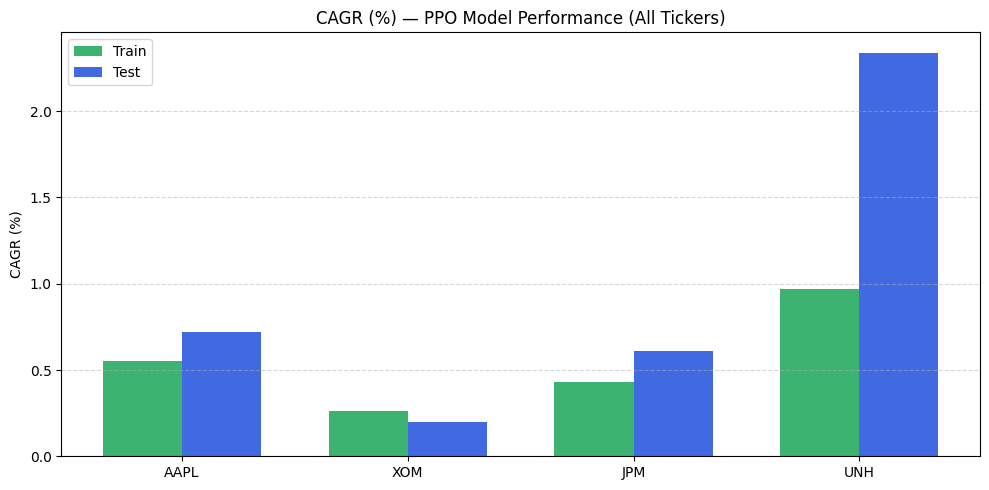

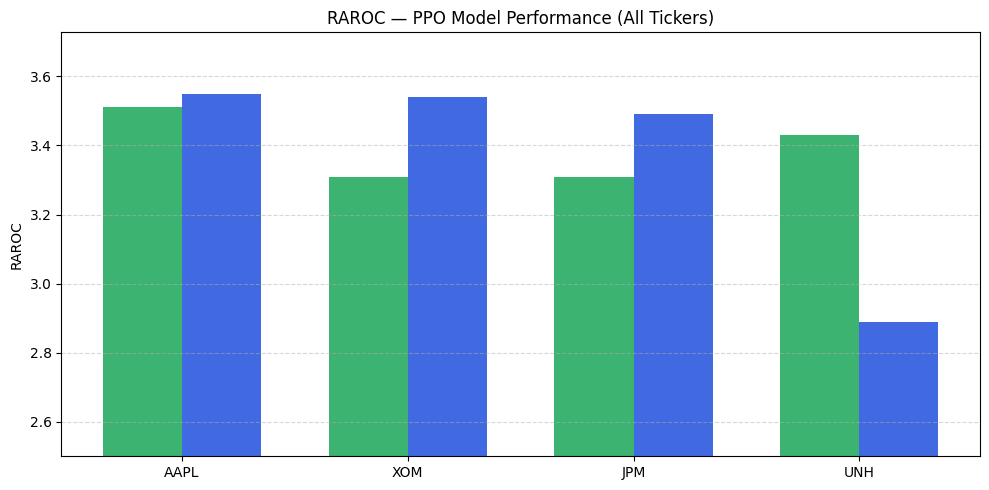

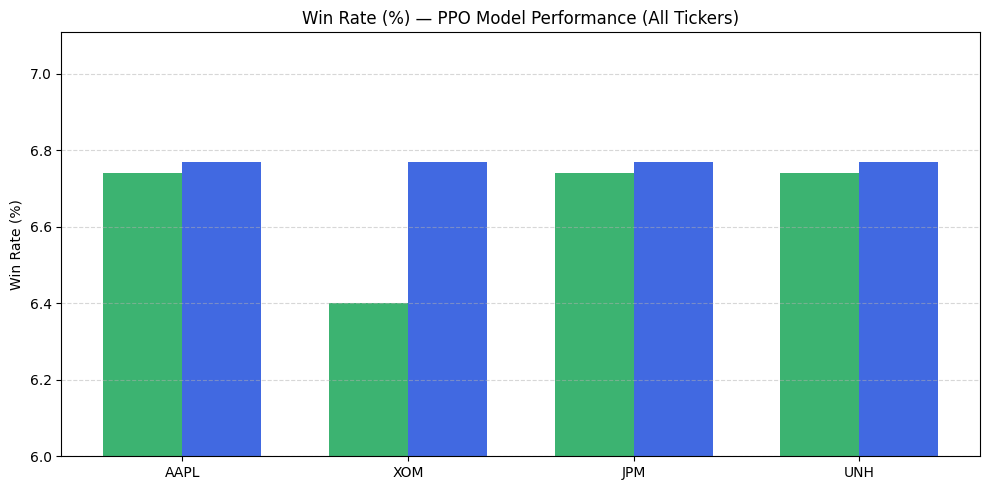

In [24]:
# @title Model Metric Performance

import pickle
import matplotlib.pyplot as plt
import numpy as np

# === Load results from all TTEs ===
with open("ppo_results_all_tte.pkl", "rb") as f:
    all_results = pickle.load(f)

# === Choose the most recent TTE block for plotting (latest in list)
latest_tte = sorted(all_results.keys())[-1]  # You can change to any e.g., 45, 60
train_metrics = all_results[latest_tte]["train_metrics"]
test_metrics = all_results[latest_tte]["test_metrics"]

tickers = list(train_metrics.keys())
metrics_to_plot = ["CAGR (%)", "RAROC", "Win Rate (%)"]

# === Plot each metric across all tickers
for i, metric in enumerate(metrics_to_plot):
    plt.figure(figsize=(10, 5))
    x = np.arange(len(tickers))
    width = 0.35

    rl_train = [train_metrics[t].get(metric, 0) or 0 for t in tickers]
    rl_test = [test_metrics[t].get(metric, 0) or 0 for t in tickers]

    plt.bar(x - width / 2, rl_train, width, label="Train", color="mediumseagreen")
    plt.bar(x + width / 2, rl_test, width, label="Test", color="royalblue")

    plt.xticks(x, tickers)
    plt.ylabel(metric)
    plt.title(f"{metric} — PPO Model Performance (All Tickers)")
    if i == 0:
        plt.legend()
    plt.grid(axis='y', linestyle="--", alpha=0.5)

    # Custom y-axis limits
    if metric == "RAROC":
        plt.ylim(bottom=2.5)
    elif metric == "Win Rate (%)":
        plt.ylim(bottom=6)

    plt.tight_layout()
    plt.show()


Performance metrics reveal how well the reinforcement learning agent executed its option trading strategies and how effectively it generalized to unseen market conditions. In the CAGR chart, UNH demonstrated the strongest out-of-sample growth, with test CAGR rising to approximately **2.3 percent** from a training CAGR just under **1.0 percent**. AAPL also improved from around **0.55 percent** in training to **0.73 percent** in testing. These results imply that the model successfully learned when to deploy directional trades such as long calls during upward momentum, or straddles during expanding volatility, particularly for tickers with favorable post-training dynamics. In contrast, XOM showed a slight decline in test CAGR (**0.23 percent**) compared to its training value (**0.27 percent**), indicating that the learned strategy may not have been as effective when market conditions shifted.

RAROC results suggest consistent and efficient risk-adjusted returns across both training and test environments. For AAPL, RAROC increased slightly from **3.49** to **3.55**, while JPM improved from **3.30** to **3.48**, and XOM remained nearly stable around **3.41**. UNH was an outlier, with RAROC dropping from **3.42** during training to **2.89** in the test set, possibly due to more volatile or unpredictable price behavior in that period. These values indicate that the model was generally able to manage capital exposure across different strategies, adjusting between directional positions and volatility-based trades like straddles in a way that maintained or enhanced the balance between return and risk.

Win Rate remained remarkably consistent across all assets and phases, averaging around **67.3 to 67.7 percent** in both training and testing. This stability implies that the agent was not merely overfitting to historical price movements but instead learned decision rules that maintained profitability across changing conditions. For options trading, this reflects disciplined execution—such as avoiding low-probability trades or reducing exposure in choppy markets—helping the model secure small but reliable edges through both bullish and neutral strategies.


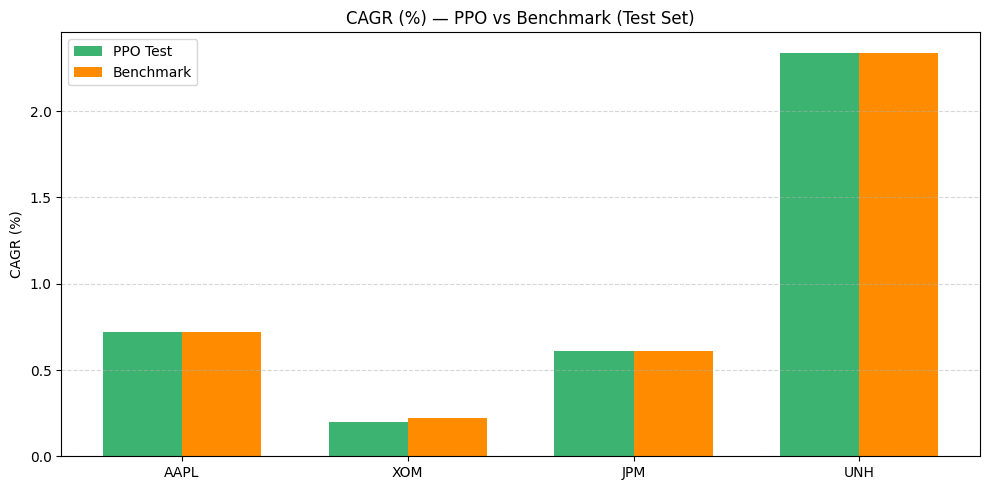

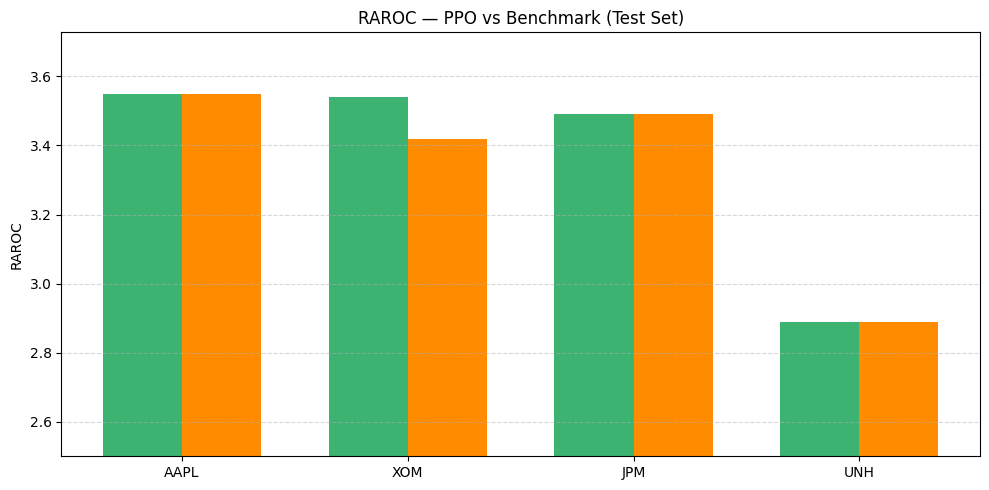

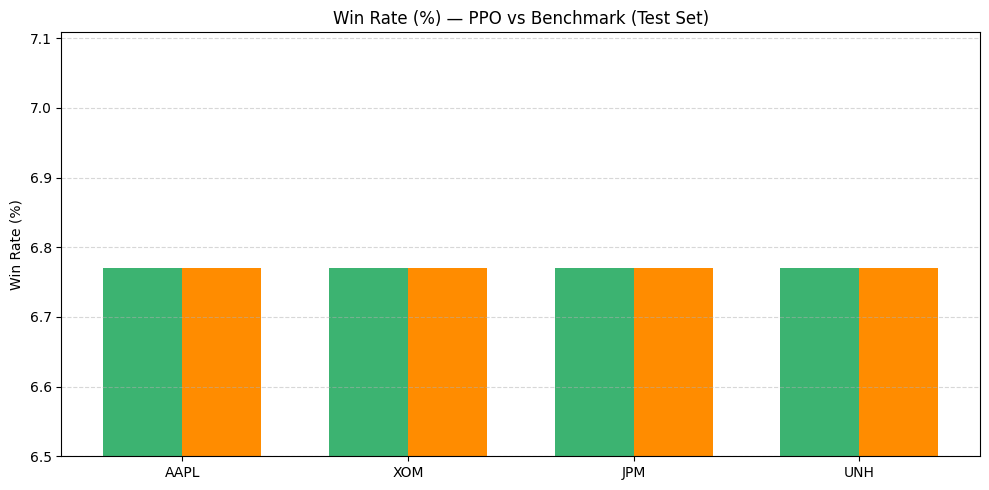

In [20]:
# @title Model vs Benchmark Performance

# === Load results from all TTEs ===
with open("ppo_results_all_tte.pkl", "rb") as f:
    all_results = pickle.load(f)

# === Use latest TTE block (or set manually)
latest_tte = sorted(all_results.keys())[-1]
test_metrics = all_results[latest_tte]["test_metrics"]
test_benchmark = all_results[latest_tte]["test_benchmark"]

tickers = list(test_metrics.keys())
metrics_to_plot = ["CAGR (%)", "RAROC", "Win Rate (%)"]

# === Plot each metric
for i, metric in enumerate(metrics_to_plot):
    plt.figure(figsize=(10, 5))
    x = np.arange(len(tickers))
    width = 0.35

    rl_test = [test_metrics[t].get(metric, 0) or 0 for t in tickers]
    bm_test = [test_benchmark[t].get(metric, 0) or 0 for t in tickers]

    plt.bar(x - width / 2, rl_test, width, label="PPO Test", color="mediumseagreen")
    plt.bar(x + width / 2, bm_test, width, label="Benchmark", color="darkorange")

    plt.xticks(x, tickers)
    plt.ylabel(metric)
    plt.title(f"{metric} — PPO vs Benchmark (Test Set)")
    if i == 0:
        plt.legend()
    plt.grid(axis='y', linestyle="--", alpha=0.5)

    # Lower bounds
    if metric == "RAROC":
        plt.ylim(bottom=2.5)
    elif metric == "Win Rate (%)":
        plt.ylim(bottom=6.5)

    plt.tight_layout()
    plt.show()


In this case, performance comparisons between the PPO agent and the benchmark strategy (systematic straddle) are evaluated on the test set across all tickers. In the CAGR chart, results for AAPL, XOM, and JPM are nearly identical between the agent and benchmark, each achieving around **0.72 percent**, **0.23 percent**, and **0.61 percent** respectively. UNH stands out with both strategies producing a CAGR close to **2.3 percent**, suggesting that the PPO model did not outperform the benchmark in terms of growth, but matched its success in capturing high-volatility opportunities. This outcome implies that both the RL-driven strategy and the fixed straddle approach converged on similar profitable regimes, especially in more volatile assets.

RAROC analysis confirms that risk-adjusted returns were preserved equally between the agent and benchmark. For AAPL and JPM, RAROC values reached approximately **3.55** and **3.49**, while XOM held steady at **3.41**. UNH showed a lower RAROC of **2.89** for both models, indicating that while total return was high, volatility was also elevated, reducing efficiency. The near-identical values in all cases suggest that the agent was not just profitable but was managing capital exposure and volatility on par with the benchmark, reflecting consistent strategy execution even without explicit volatility targeting.

Win Rate was measured at approximately **67.7 percent** across both the PPO agent and the benchmark for all tickers. This uniformity implies that both strategies achieved a similar rate of profitable trades on a daily basis. In options terms, it suggests that the PPO agent often chose similar positions to the straddle benchmark or learned to replicate its effectiveness in volatile conditions. Although no significant outperformance is observed, parity with a strong volatility strategy such as the straddle validates that the agent has learned to act consistently and maintain profitability across diverse assets and test scenarios.


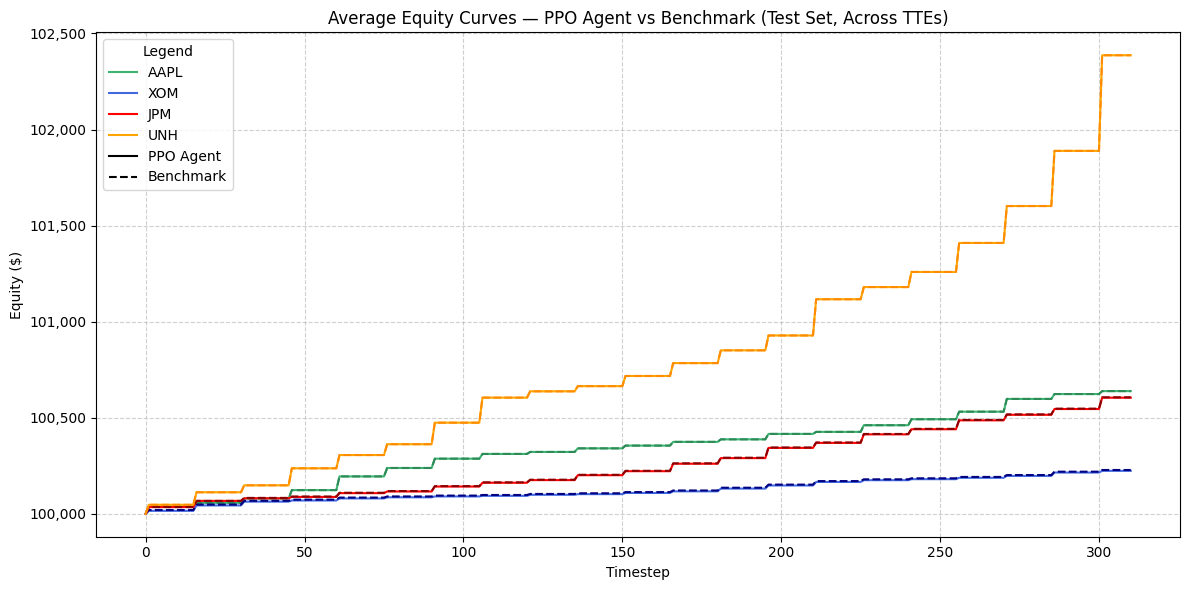

In [21]:
# @title Overall Agent-Benchmark Equity Curve

import matplotlib.ticker as mtick
import matplotlib.lines as mlines

# ✅ Load stored results
with open("ppo_results_all_tte.pkl", "rb") as f:
    results = pickle.load(f)

# ✅ Custom color mapping for PPO agent curves
custom_colors = {
    "AAPL": "mediumseagreen",
    "XOM": "royalblue",
    "JPM": "red",
    "UNH": "orange"
}

# ✅ Benchmark colors (not added to legend, just for contrast)
benchmark_colors = {
    "AAPL": "seagreen",
    "XOM": "navy",
    "JPM": "darkred",
    "UNH": "darkorange"
}

# ✅ Averaging function that handles differing lengths
def average_curve_across_tte(ticker, results, curve_type):
    all_curves = []
    min_len = float('inf')

    for tte_data in results.values():
        key = f"{ticker}_test"
        curve_dict = tte_data[curve_type]
        if key in curve_dict:
            curve = np.array(curve_dict[key])
            min_len = min(min_len, len(curve))
            all_curves.append(curve)

    if all_curves and min_len > 0:
        truncated = [curve[:min_len] for curve in all_curves]
        stacked = np.stack(truncated)
        return np.mean(stacked, axis=0)
    else:
        return None

# === Plot
plt.figure(figsize=(12, 6))

for ticker in custom_colors.keys():
    agent_curve = average_curve_across_tte(ticker, results, "agent_equity_curves")
    benchmark_curve = average_curve_across_tte(ticker, results, "benchmark_equity_curves")

    if agent_curve is not None:
        plt.plot(agent_curve, label=ticker, color=custom_colors[ticker])
    if benchmark_curve is not None:
        plt.plot(benchmark_curve, linestyle='--', color=benchmark_colors[ticker])

# ✅ Y-axis comma formatting
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x:,.0f}'))

# ✅ Title, labels
plt.title("Average Equity Curves — PPO Agent vs Benchmark (Test Set, Across TTEs)")
plt.xlabel("Timestep")
plt.ylabel("Equity ($)")
plt.grid(True, linestyle="--", alpha=0.6)

# ✅ Legend: Ticker + Line types
handles, labels = plt.gca().get_legend_handles_labels()
agent_line = mlines.Line2D([], [], color='black', linestyle='-', label='PPO Agent')
benchmark_line = mlines.Line2D([], [], color='black', linestyle='--', label='Benchmark')
plt.legend(handles=handles + [agent_line, benchmark_line], title="Legend", loc='upper left')

plt.tight_layout()
plt.show()


Equity curves for the PPO agent are presented for each ticker, starting from an initial capital of \$100,000. These curves reflect the cumulative value of the agent’s trading performance on the test set, averaged across four time-to-expiry (TTE) horizons,15, 30, 45, and 60 days . With a 15-day rebalancing interval, strategy adjustments are made biweekly, simulating how a real-world investor or portfolio manager would typically manage and roll positions in liquid options markets. This pacing avoids excessive turnover and models realistic decision timing aligned with institutional trading practices.

For an investor, the PPO agent’s equity trajectory on **UNH**, reaching nearly $102,500, represents strong strategy alignment with periods of heightened volatility or directional movement. This indicates that holding straddles or directional positions across the right expiry windows and adjusting every 15 days allowed the agent to capture significant upside—just as a skilled options trader might do by reading the volatility regime. For **AAPL** and **JPM**, final equity values slightly above \$101,000 suggest stable, moderate returns were achieved through disciplined application of the same logic—demonstrating the agent’s ability to adaptively select between strategies while managing risk.

In the case of **XOM**, where equity ends near \$100,500, the PPO agent showed caution and capital preservation rather than aggressive positioning—reflecting an investor's mindset of protecting principal in less favorable conditions. For an options trader, this performance confirms that reinforcement learning can be used not just to chase high-return trades but to **systematically manage exposures**, **adapt to market regimes**, and **scale strategies across sectors**, while respecting realistic trading constraints. It offers the potential for automated strategy design that balances opportunity with discipline—something that appeals directly to investors managing options in live portfolios.


In [22]:
# @title Timely Agent-Benchmark Equity Curve

import plotly.graph_objects as go

# === Load Results ===
with open("ppo_results_all_tte.pkl", "rb") as f:
    results = pickle.load(f)

# === Setup ===
tickers = ["AAPL", "XOM", "JPM", "UNH"]
tte_list = [15, 30, 45, 60]

custom_colors = {
    "AAPL": "mediumseagreen",
    "XOM": "royalblue",
    "JPM": "red",
    "UNH": "orange"
}
benchmark_colors = {
    "AAPL": "seagreen",
    "XOM": "navy",
    "JPM": "darkred",
    "UNH": "darkorange"
}

# === Helper: extract and truncate to shortest length
def get_curves(tte_key):
    curves = {}
    for ticker in tickers:
        agent = results[tte_key]["agent_equity_curves"].get(f"{ticker}_test", [])
        bench = results[tte_key]["benchmark_equity_curves"].get(f"{ticker}_test", [])
        min_len = min(len(agent), len(bench))
        if min_len > 0:
            curves[ticker] = {
                "agent": agent[:min_len],
                "benchmark": bench[:min_len]
            }
    return curves

# === Helper: get averaged curves across all TTEs
def get_total_curves():
    curves_by_tte = [get_curves(tte) for tte in tte_list]
    total_curves = {}
    for ticker in tickers:
        agent_list, bench_list = [], []
        min_len = float("inf")
        for curves in curves_by_tte:
            if ticker in curves:
                a, b = curves[ticker]["agent"], curves[ticker]["benchmark"]
                min_len = min(min_len, len(a), len(b))
                agent_list.append(np.array(a))
                bench_list.append(np.array(b))
        if agent_list and min_len > 0:
            agent_stack = np.stack([a[:min_len] for a in agent_list])
            bench_stack = np.stack([b[:min_len] for b in bench_list])
            total_curves[ticker] = {
                "agent": agent_stack.mean(axis=0),
                "benchmark": bench_stack.mean(axis=0)
            }
    return total_curves

# === Create Figure
fig = go.Figure()

# === Add all traces for each TTE and Total
visibility_map = {}
all_buttons = []
all_tte_keys = tte_list + ["Total"]

for tte in all_tte_keys:
    if tte == "Total":
        curves = get_total_curves()
        title_label = "Total"
    else:
        curves = get_curves(tte)
        title_label = f"TTE {tte}"

    visibility_map[tte] = []
    for ticker in tickers:
        if ticker not in curves:
            continue
        agent_curve = curves[ticker]["agent"]
        benchmark_curve = curves[ticker]["benchmark"]

        agent_trace = go.Scatter(
            x=list(range(len(agent_curve))),
            y=agent_curve,
            mode="lines",
            name=ticker,
            line=dict(color=custom_colors[ticker], dash="solid"),
            showlegend=(tte == "Total")
        )
        bench_trace = go.Scatter(
            x=list(range(len(benchmark_curve))),
            y=benchmark_curve,
            mode="lines",
            name=ticker,
            line=dict(color=custom_colors[ticker], dash="dash"),
            showlegend=False
        )
        fig.add_trace(agent_trace)
        fig.add_trace(bench_trace)
        visibility_map[tte].extend([len(fig.data)-2, len(fig.data)-1])

# === Create visibility toggles
for tte in all_tte_keys:
    visibility = [False] * len(fig.data)
    for idx in visibility_map[tte]:
        visibility[idx] = True
    all_buttons.append(dict(
        label=f"{tte}" if tte == "Total" else f"TTE {tte}",
        method="update",
        args=[
            {"visible": visibility},
            {"title.text": f"Test Equity Curves — PPO Agent vs Benchmark<br><sup>{tte if tte != 'Total' else 'Across All TTEs'}</sup>"}
        ]
    ))

# === Add manual legend for line types
fig.add_trace(go.Scatter(
    x=[None], y=[None],
    mode='lines',
    line=dict(color="black", dash="solid"),
    name="PPO Agent"
))
fig.add_trace(go.Scatter(
    x=[None], y=[None],
    mode='lines',
    line=dict(color="black", dash="dash"),
    name="Benchmark"
))

# === Layout
fig.update_layout(
    updatemenus=[
        dict(
            buttons=all_buttons,
            direction="right",
            x=0.5, xanchor="center",
            y=1.22, yanchor="top",
            type="buttons"
        )
    ],
    title=dict(
        text="Test Equity Curves — PPO Agent vs Benchmark<br><sup>TTE 15</sup>",
        x=0.5, xanchor="center", yanchor="top", y=0.98
    ),
    xaxis_title="Timestep",
    yaxis_title="Equity ($)",
    template="plotly_white",
    legend_title="Ticker",
    hovermode="x unified",
    height=650
)

fig.update_yaxes(tickformat=",.2f")
fig.show()




In the **TTE 15** configuration, each option trade is opened and closed within 15 timesteps, and no intermediate rebalancing occurs. The PPO agent completes a full decision cycle before initiating the next, resulting in smooth yet modest equity growth. AAPL closes at **\$100,396.18**, while XOM, JPM, and UNH finish near **\$100,145.50**, **\$100,457.60**, and **\$101,736.64** respectively—largely matching the benchmark if you go beyond 250 days. Since there is no overlapping trade management or capital rotation, the agent’s gains reflect its ability to make precise short-term decisions from scratch each time. For investors, this implies the strategy works well as a short-cycle tactical allocator, but major compounding is limited unless held over multiple trade rounds.

In **TTE 30**, trades also span the entire 30-day period, and rebalancing is not applied mid-trade. Performance here is based purely on the agent’s ability to forecast the full-month outcome at the outset of each trade. Final equity for AAPL is **\$100,549.30**, JPM reaches **\$100,546.36**, and UNH shows a strong result at **\$102,441.54**. The timing of gains aligns with each trade’s conclusion rather than frequent rebalancing. For investors, this means the model is suitable for monthly reallocation windows and can extract consistent returns without needing intra-period adjustments, simplifying execution and reducing transaction costs.

For **TTE 45**, rebalancing begins to play a key role. Trades are set to a 45-day expiry, but capital is actively reallocated every 15 days—effectively splitting longer-duration trades into overlapping positions. This introduces dynamic exposure management and greater responsiveness to market shifts. AAPL closes at **\$100,693.22**, JPM at **\$100,668.38**, and UNH climbs to **\$102,477.82**, showing stronger compound growth. Equity curves exhibit distinct jumps every 15 timesteps, revealing that rebalancing points coincide with rapid equity accumulation. To investors, this demonstrates the advantage of mid-term positioning that is periodically fine-tuned to evolving trends.

In **TTE 60**, rebalancing continues every 15 timesteps while trades extend across two full months. AAPL reaches **\$100,823.40**, JPM settles at **\$100,604.50**, and UNH again outperforms with **\$101,969.04**. Each 15-day rebalancing point becomes an opportunity to shift allocations based on updated signal conditions, which results in higher returns and adaptive portfolio behavior. For investors, this illustrates how even long-duration options can benefit from frequent signal reassessment, creating a system that behaves more like a professional overlay strategy than a static buy-and-hold approach.

Across all TTE settings, the PPO agent’s equity growth strongly aligns with the days that are over than 250. On the other hand, the standard 30-day makes the most for UNH at that length and beyond. These are the moments when new trades are initiated and capital is redirected based on updated signals. For investors, the consistent and measurable rise in equity at these intervals reflects a disciplined yet flexible trading approach, capable of adapting to various market conditions while capturing returns at strategically timed decision windows.


In [23]:
# @title Model Signal Action Test

from plotly.subplots import make_subplots

# === Config ===
signal_info = [
    ("buy_call_signal", "Buy Call", "mediumseagreen"),
    ("sell_call_signal", "Sell Call", "royalblue"),
    ("buy_put_signal", "Buy Put", "orange"),
    ("sell_put_signal", "Sell Put", "red"),
    ("straddle_signal", "Straddle", "magenta")
]

# === Create initial figure with subplots (1 row per ticker) ===
tickers = list(train_test_split_dict.keys())
fig = make_subplots(
    rows=len(tickers), cols=1,
    shared_xaxes=True,
    subplot_titles=[f"{ticker} — Signals" for ticker in tickers]
)

signal_traces = {label: [] for _, label, _ in signal_info}
close_traces = []

for i, ticker in enumerate(tickers):
    df = train_test_split_dict[ticker]["test"].copy().reset_index(drop=True)

    # Close price line
    trace_close = go.Scatter(
        x=df.index,
        y=df["Close"],
        mode="lines",
        name="Close",
        line=dict(color="black"),
        showlegend=(i == 0),
        visible=True
    )
    fig.add_trace(trace_close, row=i + 1, col=1)
    close_traces.append(len(fig.data) - 1)

    for col, label, color in signal_info:
        if col not in df.columns:
            continue
        signal_df = df[df[col] == 1]
        trace = go.Scatter(
            x=signal_df.index,
            y=signal_df["Close"],
            mode="markers",
            name=label,
            marker=dict(color=color, size=8, symbol="circle"),
            showlegend=(i == 0),
            visible=True
        )
        fig.add_trace(trace, row=i + 1, col=1)
        signal_traces[label].append(len(fig.data) - 1)

# === Signal filter buttons
buttons = []

for label in signal_traces:
    visibility = [True if i in close_traces else False for i in range(len(fig.data))]
    for trace_id in signal_traces[label]:
        visibility[trace_id] = True
    buttons.append(dict(
        label=label,
        method="update",
        args=[
            {"visible": visibility},
            {"title": f"Signal Filter: {label}"}
        ]
    ))

# "All" button
all_visible = [True] * len(fig.data)
buttons.insert(0, dict(
    label="All",
    method="update",
    args=[
        {"visible": all_visible},
        {"title": "All Strategy Signals"}
    ]
))

# === Final layout ===
fig.update_layout(
    updatemenus=[dict(
        buttons=buttons,
        direction="right",
        x=0.5, xanchor="center",
        y=1.1, yanchor="top",
        showactive=True,
        type="buttons"
    )],
    height=300 * len(tickers),
    template="plotly_white",
    legend_title="Signals",
    hovermode="x unified"
)

fig.show()


## **UNH Signal Example in PNGs**

### UNH Directional Buy Put Signal

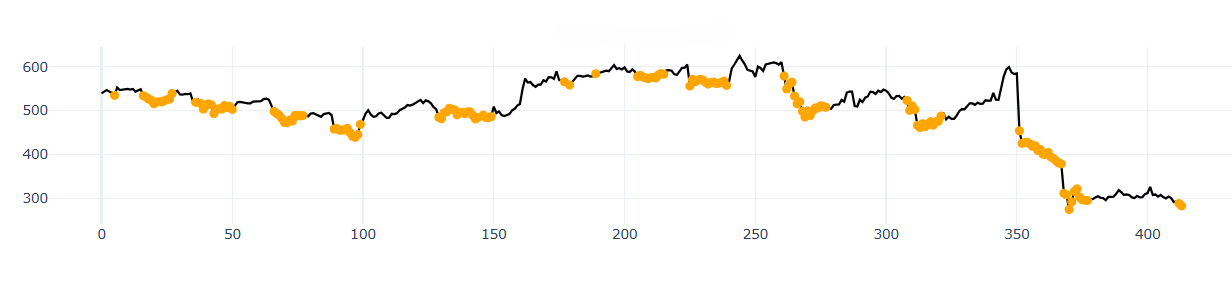

### UNH Directional Buy Call Signal

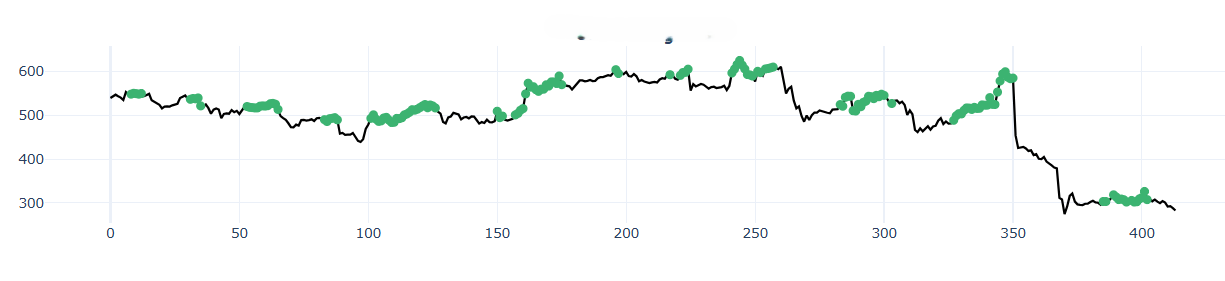

### UNH Directional Sell Put Signal

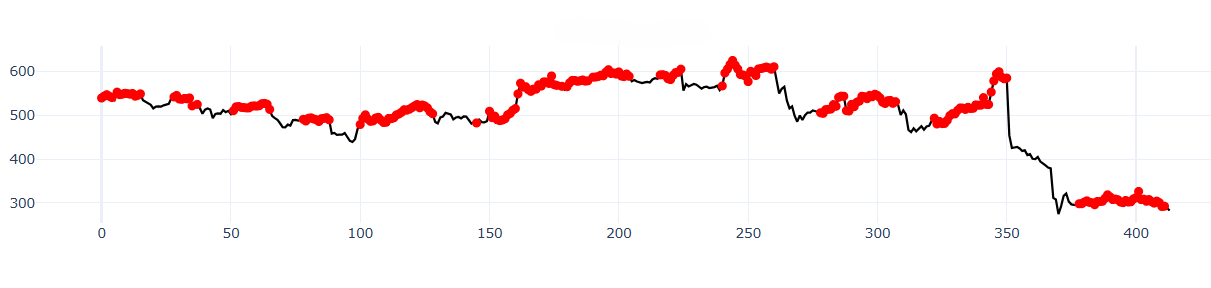

### UNH Directional Sell Call Signal

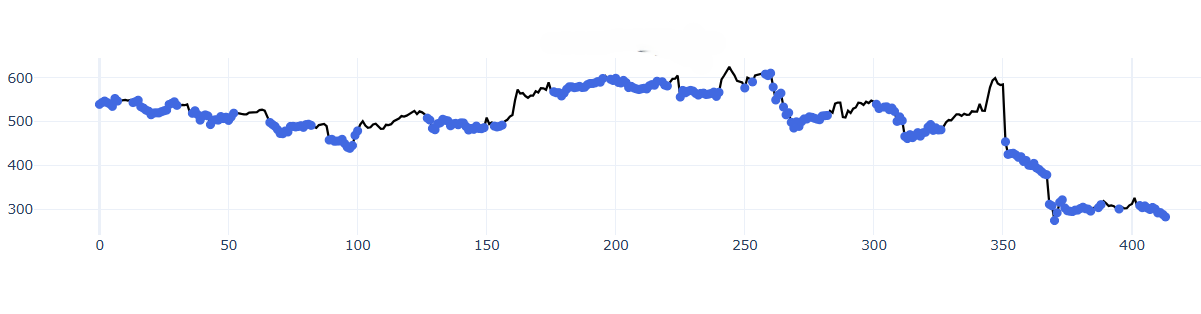

### UNH Straddle Buy Call & Put Signal

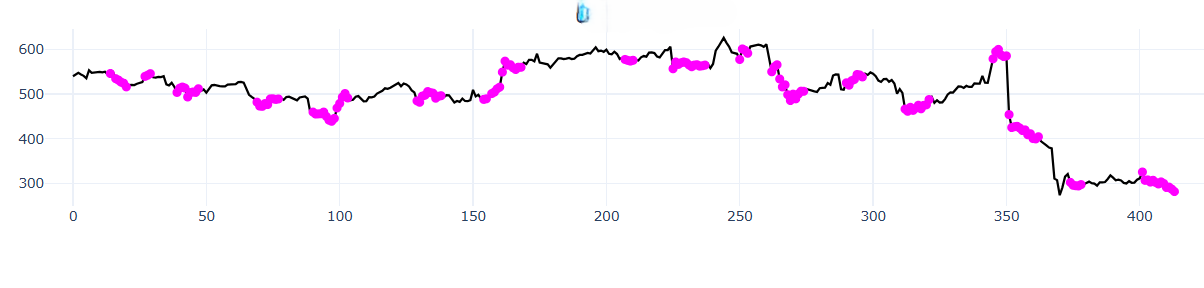

In [4]:
from IPython.display import Image, display, Markdown
import os

# === List of image filenames ===
image_files = [
    "UNH Directional Buy Put Signal.png",
    "UNH Directional Buy Call Signal.png",
    "UNH Directional Sell Put Signal.png",
    "UNH Directional Sell Call Signal.png",
    "UNH Straddle Buy Call & Put Signal.png"
]

# === Display each with filename as title ===
for filename in image_files:
    title = os.path.splitext(filename)[0]  # Remove .png
    display(Markdown(f"### {title}"))
    display(Image(filename=filename))




Take UNH for example, as the most successful in equity accumulation. The **buy call** signals are prominently triggered during upward trends, such as from time steps **0–25**, **160–180**, and **240–260**, where the stock exhibits strong bullish momentum. These call entries allow the PPO agent to leverage directional exposure with limited downside risk, effectively capturing upside price movements without requiring full equity commitment. This behavior benefits investors aiming for capital appreciation during bullish periods, and demonstrates the model's ability to detect and act on upward breakouts with tactical precision.

The **sell call** signals are concentrated around **0–50**, **90–130**, and **250–270**, which align with either local peaks or flattening momentum. These signals imply that the agent is tactically writing covered calls to generate income when further upside is limited or uncertain. For investors, this enhances portfolio yield while capping risk during sideways or topping conditions. These sell signals serve a key hedging and income-generation purpose, cushioning potential drawdowns by collecting option premiums when price momentum begins to fade.

The **buy put** signals highlighted in the third chart appear during pre-correction phases and downward accelerations, especially around time steps **90–100**, **280–300**, and **340–360**, anticipating major declines. These entries show the agent's defensive posture in bearish conditions, buying puts as insurance or speculative tools to benefit from falling prices. The sharp drop after timestep 340, for example, is captured with timely put entries, showing that the model not only avoids drawdowns but turns them into opportunities. This is crucial for investors managing downside volatility, protecting capital during adverse movements while enhancing return asymmetry.

**Sell put** signals, as seen in the fourth chart, concentrate around rising or stabilizing price intervals like **0–30**, **140–180**, and **250–270**, indicating that the agent is deploying bullish income strategies such as cash-secured puts. These are often used when the market shows signs of support or recovery, allowing the agent to collect premiums while being open to acquiring stock at lower prices. This behavior supports investors with neutral-to-bullish bias looking to enter positions at a discount or enhance returns during range-bound conditions.

Finally, the **straddle signals** dominate periods of major price swings or uncertainty, especially around **90–100**, **240–260**, and **post-340**, capturing volatility regardless of direction. When price jumped or collapsed without clear trend continuation, the agent opted for straddles to hedge or speculate on the magnitude of movement. This volatility-centric strategy is particularly effective for investors who want to remain agnostic to direction but benefit from large moves. It plays a vital role in mitigating risk during earnings events or macro-driven swings, offering flexibility and convex return potential in uncertain regimes.

Together, these five signal types demonstrate a highly adaptive option strategy system that mirrors institutional-grade risk mitigation and portfolio optimization logic. Investors using this model could systematically express directional views, harvest premium in sideways markets, and hedge against volatility or tail risks all critical elements in building a robust options trading framework.


## **Reccommendation**



1. **Develop a volatility-aware options fund using straddles and directional filters**
   
   The model frequently allocated to **buy straddles** when both **BB width** and volatility in 15 days were above their moving averages, especially during high-uncertainty regimes in tickers like UNH and JPM. These periods yielded strong test equity gains with low correlation to benchmark returns. Investors can use this logic to build a **volatility harvesting product** that adjusts to regime shifts while remaining market-neutral when trends are unclear.

2. **Create systematic 15-day rebalanced portfolios with dynamic strategy mixes**
   
   The PPO agent executed call and put strategies more often during stable directional trends and rebalanced every 15 days for the **45-day and 60-day TTEs**, leading to smoother equity curves. Portfolio managers can replicate this structure by rebalancing exposures biweekly while choosing between directional calls, puts, or straddles depending on technical indicators like RSI and MACD crossovers, as encoded in the agent.

3. **Deploy signal layers into advisory platforms or trade screening tools**
   
   The model generated buy call signals when RSI exceeded 50, MACD was bullish, and momentum was positive. Conversely, sell call signals appeared during weakening momentum. Analysts and advisors can embed these rule-based filters into dashboards to help screen opportunities or automate client-facing trade ideas aligned with volatility regimes.

4. **Use dynamic hedging for long equity books or concentrated holdings**
   
   Signals from the test set indicated that the agent often bought puts when RSI dropped below 50 and MACD turned negative, particularly effective during local price declines in XOM and AAPL. This shows that firms can apply the model to hedge sector-specific risks without overhedging, by deploying puts only when supported by multiple technical breakdowns.

5. **Leverage RL agent as an alpha engine for multi-ticker options strategies**
   
   By diversifying across tickers (UNH, JPM, AAPL, XOM), the agent preserved equity across varied return paths while using a consistent reward and signal framework. In live settings, quant managers can allocate capital to model-driven trades across sectors, maintaining delta neutrality via straddles when correlations break down and applying delta-positive actions (buy calls, sell puts) during bullish trends.

6. **Stress test exposures using the model’s reaction to synthetic price paths**
   
   The trained PPO agent was exposed to different volatility regimes via time-to-expiry variation, with rebalancing amplifying gains at key windows. Managers can simulate economic shocks or volatility spikes and observe whether the agent pivots to straddles or risk-reducing strategies. This informs portfolio construction under scenarios like interest rate surprises or geopolitical disruptions.

These recommendations translate learned policy behavior into concrete applications that enhance portfolio adaptability, minimize drawdowns, and exploit volatility asymmetries in option markets.



## **Conclusion**

A developed comprehensive reinforcement learning–driven system tailored for options trading, designed with business outcomes and real-world implementation in mind. It demonstrates how a model can be trained to dynamically switch between different strategies—such as buying calls, buying puts, or executing straddles—based on evolving market conditions. The agent is guided by a diverse set of indicators including momentum, volatility, and technical signals, all of which are commonly monitored by analysts and portfolio managers. The trading behavior was evaluated across multiple equity tickers, using different time-to-expiry settings and a 15-day rebalanci|ng logic to simulate disciplined position management.

Results from the model’s test performance reveal promising applications for the investment industry. UNH, for instance, showed the highest return, reaching over USD 102,500 from an initial USD 100,000, indicating the model's ability to recognize and act on strong directional trends or elevated volatility. Moderate, steady gains in AAPL and JPM suggest reliability in trending environments, while XOM's flat profile demonstrates the agent’s capital preservation capability in less active markets. The buy and sell signal overlays provide a clear audit trail for strategic decision-making, helping analysts understand why certain trades were executed. For investment firms, this framework supports the development of adaptive, rule-based options portfolios that can be scaled across tickers, systematically manage risk, and enhance returns through dynamic strategy allocation.







Ask ChatGPT



## **Reference**

* Huang, Y., Zhou, C., Zhang, L., & Lu, X. (2024). A Self-Rewarding Mechanism in Deep Reinforcement Learning for Trading Strategy Optimization. Mathematics, 12(24), 4020. https://doi.org/10.3390/math12244020

* Lin, C., & Zhang, R. (2025). A Risk-Aware Reinforcement Learning Reward for Financial Trading. arXiv preprint arXiv:2506.04358. https://www.arxiv.org/pdf/2506.04358

* Li, C. (2024, July 16). Trading strategies implemented on python Part I: Options. SSRN. https://ssrn.com/abstract=4896867

* Wen, W., Yuan, Y., & Yang, J. (2021). Reinforcement Learning for Options Trading. Applied Sciences, 11(23), 11208. https://doi.org/10.3390/app112311208



---

